# Dense Deep Neural Network: Handwritten Digit Recognition

This notebook uses the classic [MNIST handwritten digit](http://yann.lecun.com/exdb/mnist/) dataset, which contains digit 0-9 images of size 28*28. We build a dense neural network to predict the class of digit.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## The MNIST dataset

### Get the data
MNIST dataset is provided by Keras directly. The following codes show how to load it. 

In [2]:
help(mnist.load_data)

Help on function load_data in module keras.datasets.mnist:

load_data(path='mnist.npz')
    Loads the MNIST dataset.
    
    This is a dataset of 60,000 28x28 grayscale images of the 10 digits,
    along with a test set of 10,000 images.
    More info can be found at the
    [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
    
    Args:
      path: path where to cache the dataset locally
        (relative to `~/.keras/datasets`).
    
    Returns:
      Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.
    
    **x_train**: uint8 NumPy array of grayscale image data with shapes
      `(60000, 28, 28)`, containing the training data. Pixel values range
      from 0 to 255.
    
    **y_train**: uint8 NumPy array of digit labels (integers in range 0-9)
      with shape `(60000,)` for the training data.
    
    **x_test**: uint8 NumPy array of grayscale image data with shapes
      (10000, 28, 28), containing the test data. Pixel values range
      from 0 to 255.
    
  

In [2]:
# the data, shuffled and split between train and test sets 
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = mnist.load_data()

### Reshape and normalize the features

In [5]:
input_dim = 784 # 28*28
X_train = X_train_pre.reshape(X_train_pre.shape[0], input_dim) 
X_test = X_test_pre.reshape(X_test_pre.shape[0], input_dim) 
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train /= 255. #normalize
X_test /= 255. #normalize

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 784)
60000 train samples, 10000 test samples


### convert class vectors to binary class matrices
convert class label to one-hot coding

In [7]:
num_classes = 10 # 0-9
y_train = keras.utils.to_categorical(y_train_pre, num_classes)
y_test = keras.utils.to_categorical(y_test_pre, num_classes)
# the first 5 samples are 5,0,4,1,9
y_train[:5,] 

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [12]:
# split train, validation in train
# Regularization: 1) Ridge/Lasso. 2) Droopout. 3) Early stopping
# overparametrize: when #parameters >= #sample
# input layer: 784
#              (784+1)*512
# first layer: 512
#              (512+1)*128
# second layer: 128
#              (128+1)*10
# output layer: 10

validation_split = 0.166667
index = np.random.permutation(X_train.shape[0]) #random

train_idx = int(X_train.shape[0]*validation_split) #integer

X_val, X_train = X_train[index[:train_idx]], X_train[index[train_idx:]] #get valid one after randomization
y_val, y_train = y_train[index[:train_idx]], y_train[index[train_idx:]]

print('training data shape:', X_train.shape)
print('{} train samples, {} validation samples, {} test samples'\
      .format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))
      
print(X_val.shape, X_train.shape, y_val.shape, y_train.shape)

training data shape: (41667, 784)
41667 train samples, 8333 validation samples, 10000 test samples
(8333, 784) (41667, 784) (8333, 10) (41667, 10)


## The model

### Build the model

In [13]:
#from keras.layers import Dropout

model = keras.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(784,))) #first hidden layer
model.add(layers.Dense(128, activation='relu')) #second hidden layer
model.add(layers.Dense(10, activation='softmax')) #output layer
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(0.001),
              metrics=['accuracy'])
#change loss function (how the machine learn), metrics(use for evaluation) --> accuracy

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [15]:
EPOCHS = 20

history = model.fit(X_train, y_train,
                    batch_size=128, epochs=EPOCHS,
                    validation_data=(X_val, y_val))

# batch size = 128, sample size n = 5000
# run 50000/128次iterations
# *上EPOCHS = 20*50000/128 iterations
# the larger the model is, the more batch size we should set

# result: training loss is getting smaller，accuracy is getting higher；but not the ablosute case in validation loss，so does accuracy
# compared to epoch in logistics model, the loss drops significantly in  the second DNN --> good thing

Epoch 1/20
326/326 [==============================] - 7s 16ms/step - loss: 0.2826 - accuracy: 0.9140 - val_loss: 0.1324 - val_accuracy: 0.9609
Epoch 2/20
326/326 [==============================] - 5s 14ms/step - loss: 0.1077 - accuracy: 0.9670 - val_loss: 0.1012 - val_accuracy: 0.9718
Epoch 3/20
326/326 [==============================] - 5s 15ms/step - loss: 0.0672 - accuracy: 0.9786 - val_loss: 0.0841 - val_accuracy: 0.9740
Epoch 4/20
326/326 [==============================] - 5s 15ms/step - loss: 0.0462 - accuracy: 0.9854 - val_loss: 0.0963 - val_accuracy: 0.9728
Epoch 5/20
326/326 [==============================] - 5s 15ms/step - loss: 0.0338 - accuracy: 0.9889 - val_loss: 0.0796 - val_accuracy: 0.9806
Epoch 6/20
326/326 [==============================] - 5s 15ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.0949 - val_accuracy: 0.9767
Epoch 7/20
326/326 [==============================] - 5s 15ms/step - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.1070 - val_accuracy: 0.9729

,loss,accuracy,val_loss,val_accuracy,epoch
15,0.003606,0.998824,0.155319,0.978279,15
16,0.003446,0.998968,0.147858,0.980559,16
17,0.002812,0.999064,0.145482,0.980199,17
18,0.003941,0.998896,0.176917,0.977559,18
19,0.003643,0.998656,0.169613,0.978999,19


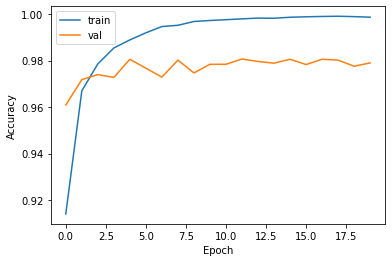

In [16]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    display(hist.tail())

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label="train")
    plt.plot(hist['epoch'], hist['val_accuracy'], label="val")
    plt.legend()
    plt.show()

plot_history(history)

### Make predictions

Calculate the classification accuracy for testing set

In [17]:
_, acc = model.evaluate(X_test, y_test, verbose=0)

print("Testing set accuracy: {:.2f}%".format(acc*100))

#assignment1 goal: change activation function to beat this accuracy

Testing set accuracy: 97.86%


Make predictions for testing data

In [18]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_pred[:5]

array([7, 2, 1, 0, 4], dtype=int64)

Visualize predictions

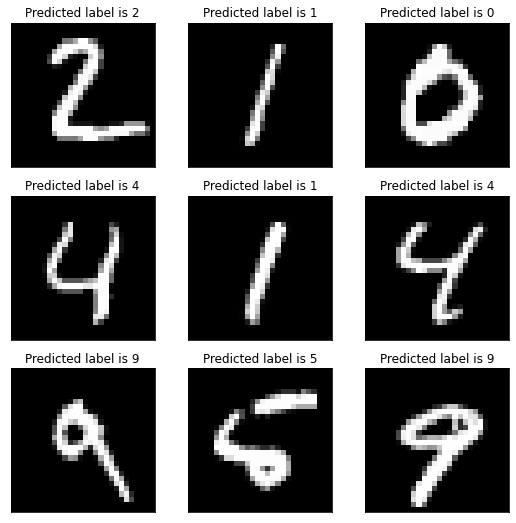

In [21]:
fig = plt.figure(figsize=(9, 9))
col = 3
row = 3
for i in range(1, col*row +1):
    pred = y_pred[i]
    img = X_test_pre[i,:]
    fig.add_subplot(row, col, i)
    plt.title('Predicted label is {}'.format(pred))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()

## Early Stopping
do not need to wait for the completion of EPOCHS = 20
* Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

In [22]:
EPOCHS = 20

# training loss keeps decreading
# valifation loss decrease and then increase, so we want to stop at the minimum of validation loss => early stopping
# small batch size --> larger patience, there is local minimum and gloab minimum in validation loss

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# monitor: metric
# patience=0: is the number of epochs with no improvement.
#             The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.
# patience=2, try 3 times
# stop at 5th Epoch
#

history = model.fit(X_train, y_train,
                    batch_size=128, epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/20
326/326 [==============================] - 5s 15ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.1644 - val_accuracy: 0.9804
Epoch 2/20
326/326 [==============================] - 5s 15ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1862 - val_accuracy: 0.9810
Epoch 3/20
326/326 [==============================] - 5s 14ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.1601 - val_accuracy: 0.9818
Epoch 4/20
326/326 [==============================] - 5s 14ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.1842 - val_accuracy: 0.9789
Epoch 5/20
326/326 [==============================] - 5s 14ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.1655 - val_accuracy: 0.9803


In [23]:
_, acc = model.evaluate(X_test, y_test, verbose=0)

print("Testing set accuracy: {:.2f}%".format(acc*100))

Testing set accuracy: 97.84%
